### Histopathologic Cancer Detection project (Step 1)

The objective of this assesment is to identify metastatic tissue in histopathologic scans of lymph node sections

The dataset for it is composed of a set of 220k+ images from lymph node section scans, each with a unique ID, and 
a train_labels.csv file that maps the images by id to a label 1 or 0, depending on wether the scan shows cancerous tissue or not.
The images are in .tif format, 96x96 RGB, about 29kb each.
Note: only the center 32x32 seems to be what dictates if the label is 0 or 1.






### Basic dataset analysis (Step 2)

We are trying to understand the shape of the dataset, label counts, and the positive to negative ratio

Training labels shape: (220025, 2)

First couple of rows:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Missing value count for training labels:2

Count of duplicate labels: 0

Label distribution:
0 (Negative): 130908 - 0.59%
1 (Positive): 89117 - 0.41%

Positive/Negative ratio: 0.6808


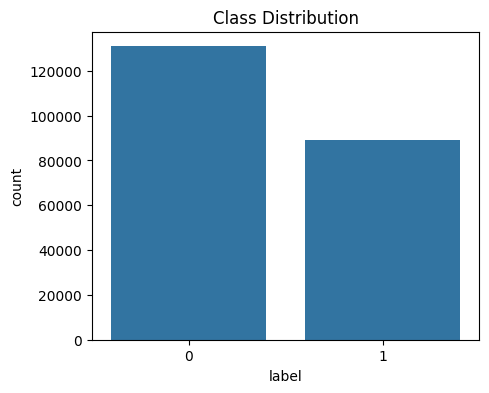

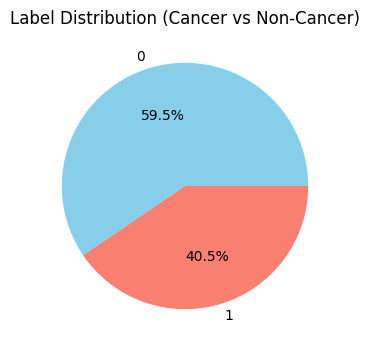

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

SEPARATOR = "\n=======================================\n"

input_dir = 'histopathologic-cancer-detection'

train_labels = pd.read_csv(f"{input_dir}/train_labels.csv")
train_images_dir = f"{input_dir}/train"

print(f"Training labels shape: {train_labels.shape}")
print(f"{SEPARATOR}First couple of rows:")
print(train_labels.head())
print(f"{SEPARATOR}Missing value count for training labels:{len(train_labels.isnull().sum())}")

print(f"{SEPARATOR}Count of duplicate labels: {len(train_labels[train_labels.duplicated(keep=False)])}")

label_counts = train_labels['label'].value_counts()
print(f"{SEPARATOR}Label distribution:")
total = train_labels.shape[0]

print(f"0 (Negative): {label_counts[0]} - {round(label_counts[0]/total,2)}%")
print(f"1 (Positive): {label_counts[1]} - {round(label_counts[1]/total,2)}%")
ratio = label_counts[1] / label_counts[0]
print(f"\nPositive/Negative ratio: {ratio:.4f}")

plt.figure(figsize=(5,4))
sns.countplot(x='label', data=train_labels, legend=False)
plt.title("Class Distribution")
plt.show()

plt.figure(figsize=(5,4))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=["skyblue", "salmon"])
plt.title("Label Distribution (Cancer vs Non-Cancer)")
plt.show()

#### Image analysis
- Checking if all ids referenced in the train_labels file exist as images
- Check out dimenstions
- Display a couple of random images to understand what we are working with.

Missing images: 0

Unique image sizes in 100 random samples: {(96, 96)}


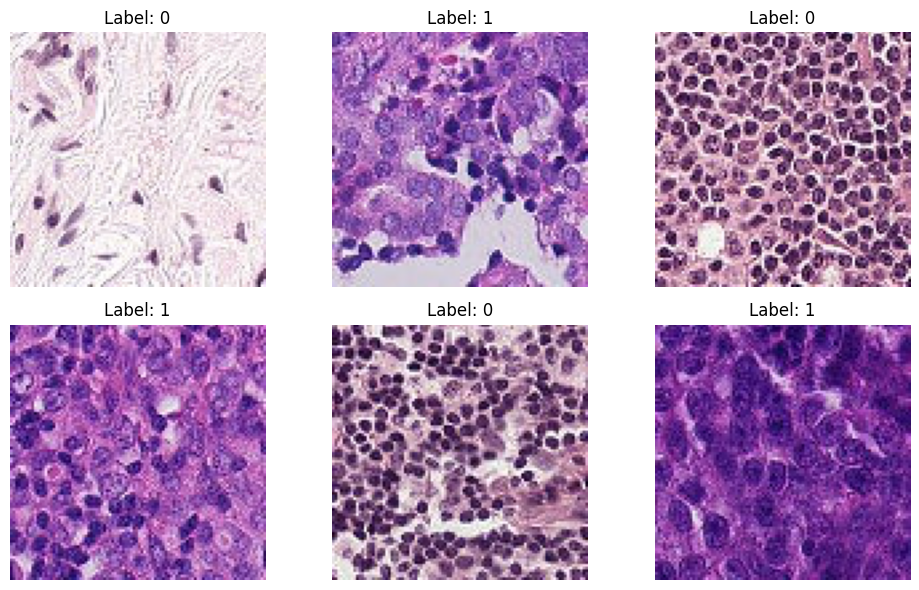

In [86]:
import os
from PIL import Image
import random

missing_images = sum(~train_labels['id'].apply(lambda x: os.path.exists(f"{train_images_dir}/{x}.tif")))
print(f"Missing images: {missing_images}")

img_sizes = [Image.open(f"{train_images_dir}/{f}.tif").size for f in train_labels['id'].sample(100)]
print(f"{SEPARATOR}Unique image sizes in 100 random samples:", set(img_sizes))

sample_ids = train_labels.sample(6)
plt.figure(figsize=(10,6))
for i, (img_id, label) in enumerate(zip(sample_ids['id'], sample_ids['label'])):
    img = Image.open(f"{train_images_dir}/{img_id}.tif")
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Looks like there are no missing images, and from a couple of runs it looks like all images are effectively 96x96

#### Checking class balance across random splits

This is useful because I'll be splitting the dataset into train/validation/test

In [45]:
from sklearn.model_selection import train_test_split

print("Train and validation split ratios across 4 random splits:\n\n")
for i in range(4):
    train_df, val_df = train_test_split(train_labels, test_size=0.2, stratify=train_labels['label'])
    train_counts = train_df['label'].value_counts(normalize=True)
    print(f"Train 0: {round(train_counts[0],4)} -- 1: {round(train_counts[1],4)}")
    validation_counts = val_df['label'].value_counts(normalize=True)
    print(f"\nValidation 0: {round(validation_counts[0],4)} -- 1: {round(validation_counts[1],4)}")
    
    print(SEPARATOR)

Train and validation split ratios across 4 random splits:


Train 0: 0.595 -- 1: 0.405

Validation 0: 0.595 -- 1: 0.405


Train 0: 0.595 -- 1: 0.405

Validation 0: 0.595 -- 1: 0.405


Train 0: 0.595 -- 1: 0.405

Validation 0: 0.595 -- 1: 0.405


Train 0: 0.595 -- 1: 0.405

Validation 0: 0.595 -- 1: 0.405




Looks like it's pretty safe to split our dataset, we always get a very similar ratio

In [51]:
id_set = set()
for id in train_labels["id"]:
    id_set.add(id)

if len(id_set)==len(train_labels):
    print("No duplicate IDs found")
else:
    print("Duplicates found")

print(f"{SEPARATOR}Available labels")
print(train_labels["label"].unique())

No duplicate IDs found

Available labels
[0 1]


#### Checking for duplicate IDs and available labels in the training data

Looks like I don't have to worry about duplicates, this was stated in the Kaggle challenge but I wanted to validate just in case. Labels are just 0 and 1 too.

#### Checking pixel intensity distribution

We'll check across 1000 images from each label

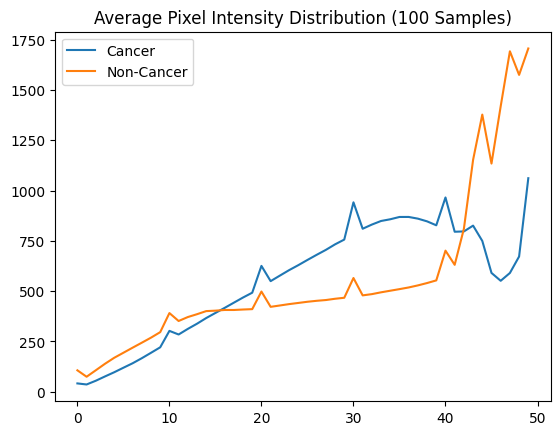

In [58]:
import numpy as np

def avg_histogram(img_ids, bins=50):
    hists = []
    for img_id in img_ids:
        arr = get_image_array(img_id)
        hist, _ = np.histogram(arr, bins=bins, range=(0,255))
        hists.append(hist)
    return np.mean(hists, axis=0)

cancer_ids = train_labels[train_labels['label']==1]['id'].sample(1000)
noncancer_ids = train_labels[train_labels['label']==0]['id'].sample(1000)

cancer_hist = avg_histogram(cancer_ids)
noncancer_hist = avg_histogram(noncancer_ids)

plt.plot(cancer_hist, label="Cancer")
plt.plot(noncancer_hist, label="Non-Cancer")
plt.legend()
plt.title("Average Pixel Intensity Distribution (1000 Samples)")
plt.show()

### EDA Summary

The dataset seems to be pretty clean:
- All ids in the training data have a corresponding image
- All images are the same format and size (96x96)
- There aren't duplicates
- Non cancer/cancel label distrubution seems to be 60% / 40%, this is a strong class imbalance.
- When splitting the dataset the ratio doesn't seem to change
- A pixel intensity distribution analysis doesn't seem to come up with any significant difference, which makes sense because it's more about the shape than the color

Plan of analysis:
- Stratified splits for the train/validation/test sets
- Class weighting is needed to address the class imbalance



### Model Architecture (Step 3)

- Using keras to build the CNN
- Splitting data into train / validation / test 70% / 15% / 15%
- Setting up batches of 128 images and adding some augmentations to improve the generalization. These augmentations (light rotation,contrast,zoom and flip) are useful because orientation and the other attributes shouldn't matter when analyzing images.

#### Structure
Kernel size is always 3x3 but we change the amount of filters by layer
- Block1 (96=>48): Conv(32,3) => BN => ReLU => Conv(32,3) => BN => ReLU => MaxPool(2)
- Block2 (48=>24): Conv(64,3) => BN => ReLU => Conv(64,3) => BN => ReLU => MaxPool(2)
- Block3 (24=>12): Conv(128,3) => BN => ReLU => Conv(128,3) => BN => ReLU => MaxPool(2)
- Neck: Conv(256,1) => BN => ReLU
- Head: GlobalAveragePooling2D => Dropout(0.4) => Dense(1, activation=None)

Also training a smaller model for comparison and to establish if the additional layers make it perform better

#### Training
- Loss: BinaryCrossentropy(from_logits=True)
  -	We output a single logit (logit is a raw output value without squashing it with an activation function). We are targeting a binary choice here so no need for softmax or anything else.
- Optimizers: Adam, AdamW and SGD
  - Exploring different optimizers at two different learning rates to find the most efficient combination.
- Metrics: ROC-AUC and PR-AUC
- Class weights: {0: N/(2*N0), 1: N/(2*N1)} computed only on train_df
- Callbacks: ModelCheckpoint(monitor="val_auc"), EarlyStopping(val_auc, patience≈5), ReduceLROnPlateau(val_auc)
  - These help us stop early and roll back to the best epoch if gains stall. When we find a plateau, we reduce the learning rate to find a better local optimum


In [66]:
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = 96
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE
 
def path_for_id(img_id: tf.Tensor) -> tf.Tensor:
    return tf.strings.join([input_dir, "/train/", img_id, ".tif"])

def load_image(img_path):
    def _read_numpy(p):
        from PIL import Image
        import numpy as np
        p = p.decode("utf-8")  # bytes -> str
        with Image.open(p) as im:
            im = im.convert("RGB")
            im = im.resize((IMG_SIZE, IMG_SIZE))
            arr = np.asarray(im, dtype=np.float32) / 255.0
        return arr

    img = tf.numpy_function(_read_numpy, [img_path], tf.float32)
    img.set_shape((IMG_SIZE, IMG_SIZE, 3))
    return img

def make_ds(sub_df, augment=False, shuffle=False):
    paths = tf.constant(sub_df["id"].values)
    labels = tf.constant(sub_df["label"].values, dtype=tf.int32)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(sub_df), reshuffle_each_iteration=True)

    def _map(img_id, y):
        x = load_image(path_for_id(img_id))
        if augment:
            x = data_augment(x)
        return x, tf.cast(y, tf.float32)

    ds = ds.map(_map, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# Light augmentations
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augment")

## First split: train vs temp (val+test)
train_df, temp_df = train_test_split(
    train_labels, test_size=0.3, stratify=train_labels["label"], random_state=42
)

# Second split: val vs test
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

train_ds = make_ds(train_df, augment=True, shuffle=True)
val_ds   = make_ds(val_df, augment=False, shuffle=False)
test_ds  = make_ds(test_df, augment=False, shuffle=False)

# Class weights
neg, pos = np.bincount(train_labels["label"])
total = neg + pos
class_weight = {0: total/(2.0*neg), 1: total/(2.0*pos)}
class_weight

Train: 154017 Val: 33004 Test: 33004


{0: np.float64(0.840380267057781), 1: np.float64(1.234472659537462)}

In [81]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    return x

# Building the main model
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = conv_block(inputs, 32)
x = conv_block(x, 64)
x = conv_block(x, 128)
x = layers.Conv2D(256, 1, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
logits = layers.Dense(1, activation=None)(x)
main_model = models.Model(inputs, logits, name="Week3CNN")

main_model.summary()

print(SEPARATOR)
print(SEPARATOR)

# Building a basic model with a simpler architecture just for comparison
inputs2 = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x2 = conv_block(inputs2, 32)
x2 = conv_block(x2,32)
x2 = conv_block(x2,64)
x2 = layers.Conv2D(128, 1, use_bias=False)(x2)
x2 = layers.ReLU()(x2)
x2 = layers.GlobalAveragePooling2D()(x2)
logits2 = layers.Dense(1,activation=None)(x2)
base_model = models.Model(inputs2,logits2, name="Week3BasicCNN")

base_model.summary()

Model: "Week3CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 96, 96, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_112 (ReLU)                │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 96, 96, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_113 (ReLU)                │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 48, 48, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_109         │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_114 (ReLU)                │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 48, 48, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_110         │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_115 (ReLU)                │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 24, 24, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_111         │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_116 (ReLU)                │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 24, 24, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_117 (ReLU)                │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 12, 12, 128)    │             

 Total params: 322,401 (1.23 MB)

 Trainable params: 320,993 (1.22 MB)

 Non-trainable params: 1,408 (5.50 KB)

Model: "Week3BasicCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 96, 96, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_119 (ReLU)                │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_120 (Conv2D)             │ (None, 96, 96, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_120 (ReLU)                │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 48, 48, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_121 (ReLU)                │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_122 (Conv2D)             │ (None, 48, 48, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_122 (ReLU)                │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_123 (Conv2D)             │ (None, 24, 24, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_118         │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_123 (ReLU)                │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 24, 24, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_119         │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_124 (ReLU)                │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 12, 12, 64)     │             

 Total params: 93,153 (363.88 KB)

 Trainable params: 92,641 (361.88 KB)

 Non-trainable params: 512 (2.00 KB)

### Training both models with different learning rates and optimizers

Some hyperparameters are already varying in the models, so focusing on the learning rates and optimizers for this part

In [85]:
learning_rates = [0.003, 0.03]
optimizers = [tf.keras.optimizers.Adam, tf.keras.optimizers.AdamW, tf.keras.optimizers.SGD]

# Doing just 2 epochs to observe behavior for now
epochs = 2

# Keeping these static for now, I'll just explore learning rates and optimizers
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [
    tf.keras.metrics.AUC(curve="ROC", name="auc"),
    tf.keras.metrics.AUC(curve="PR",  name="auprc"),
]

models = dict()

for model in [base_model, main_model]:
    models[model.name] = dict()
    for lr in learning_rates:
        models[model.name][lr] = dict()
        for optimizer in optimizers:
            opt_name = optimizer.__name__
            models[model.name][lr][opt_name] = dict()
            
            opt = optimizer(learning_rate=lr)
            callbacks = [
                tf.keras.callbacks.ModelCheckpoint("best.keras", monitor="val_auc", mode="max", save_best_only=True),
                tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=lr*0.25),
            ]
    
            print(f"Model: {model.name} -- Optimizer: {opt_name} -- Learning rate: {lr}")
            model.compile(optimizer=opt,loss=loss,metrics=metrics)
            models[model.name][lr][opt_name]["history"] = model.fit(train_ds,validation_data=val_ds,epochs=epochs,class_weight=class_weight,callbacks=callbacks)
            models[model.name][lr][opt_name]["model"] = model
            
            print(SEPARATOR)
        print(SEPARATOR)





Model: Week3BasicCNN -- Optimizer: Adam -- Learning rate: 0.003
Epoch 1/2
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 560s 463ms/step - auc: 0.9201 - auprc: 0.8970 - loss: 0.2361 - val_auc: 0.5096 - val_auprc: 0.4339 - val_loss: 1.2030 - learning_rate: 0.0030
Epoch 2/2
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 654s 543ms/step - auc: 0.9282 - auprc: 0.9081 - loss: 0.2148 - val_auc: 0.8779 - val_auprc: 0.8869 - val_loss: 0.2714 - learning_rate: 0.0030




Model: Week3BasicCNN -- Optimizer: AdamW -- Learning rate: 0.003
Epoch 1/2
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 660s 544ms/step - auc: 0.9230 - auprc: 0.9088 - loss: 0.2035 - val_auc: 0.7441 - val_auprc: 0.7679 - val_loss: 0.5068 - learning_rate: 0.0030
Epoch 2/2
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 655s 544ms/step - auc: 0.9363 - auprc: 0.9188 - loss: 0.1930 - val_auc: 0.8656 - val_auprc: 0.8614 - val_loss: 0.3106 - learning_rate: 0.0030




Model: Week3BasicCNN -- Optimizer: SGD -- Learning rate: 0.003
Epoch 1/2
1204/1204 ━━━━━━━━━━━━━━━━━━━━ 639s 530ms/step - auc: 0.

### Training results analysis (Step 4)

Surprising results, even though we only trained 2 epochs. With longer training, the bigger model might actually train better.

It seems like the basic model performed significantly better at a learning rate of 0.003 with an SGD optimizer.

Overall, SGD outperformed Adam by a noticeable margin. Adam and AdamW seem to be pretty similar for this problem in terms of performance.

Another thing to notice is that the basic model with SGD seems to have a decent Validation set loss, which means that it's not overfitting.

In [87]:
print("Training results summary")

rows = []
for model_name, by_lr in models.items():
    for lr, by_opt in by_lr.items():
        for opt_name, bundle in by_opt.items():
            hist = bundle["history"].history
            epochs = len(hist["loss"])
            best_idx = int(np.argmax(hist["val_auc"]))
            rows.append({
                "model": model_name,
                "optimizer": opt_name,
                "lr": lr,
                "epochs_run": epochs,
                "best_epoch": best_idx + 1,
                "val_auc_best": float(hist["val_auc"][best_idx]),
                "val_auprc_best": float(hist["val_auprc"][best_idx]),
                "train_auc_at_best": float(hist["auc"][best_idx]),
                "train_loss_at_best": float(hist["loss"][best_idx]),
                "val_loss_at_best": float(hist["val_loss"][best_idx]) if "val_loss" in hist else np.nan,
            })
summary_df = pd.DataFrame(rows).sort_values(["val_auc_best","val_auprc_best"], ascending=[False, False]).reset_index(drop=True)
summary_df.head(10)

Training results summary


,model,optimizer,lr,epochs_run,best_epoch,val_auc_best,val_auprc_best,train_auc_at_best,train_loss_at_best,val_loss_at_best
0,Week3BasicCNN,SGD,0.003,2,2,0.931131,0.924605,0.944615,0.172564,0.181036
1,Week3CNN,SGD,0.003,2,2,0.927580,0.914352,0.936673,0.195019,0.203305
2,Week3CNN,SGD,0.030,2,2,0.916946,0.919151,0.932678,0.204052,0.192378
3,Week3BasicCNN,SGD,0.030,2,2,0.902783,0.908568,0.933658,0.204273,0.219187
4,Week3BasicCNN,Adam,0.003,2,2,0.877898,0.886858,0.928190,0.214844,0.271396
5,Week3BasicCNN,AdamW,0.003,2,2,0.865606,0.861408,0.936312,0.193048,0.310648
6,Week3CNN,Adam,0.003,2,2,0.846936,0.860782,0.902247,0.279614,0.310523
7,Week3CNN,AdamW,0.003,2,2,0.826819,0.829152,0.927424,0.217943,0.364028
8,Week3BasicCNN,AdamW,0.030,2,2,0.824016,0.843918,0.919275,0.237017,0.331996
9,Week3CNN,AdamW,0.030,2,1,0.704522,0.717537,0.871348,0.238454,0.708664


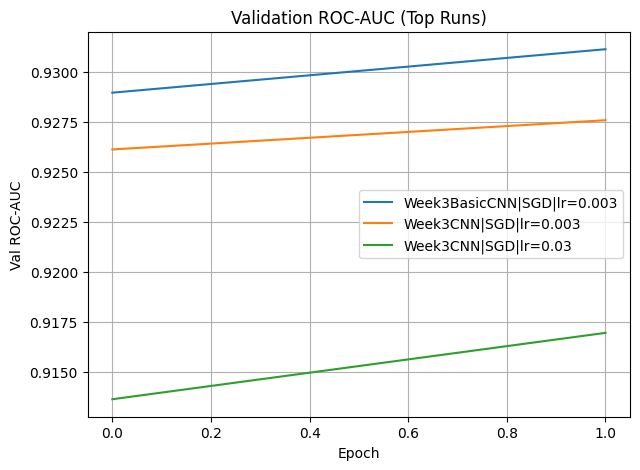

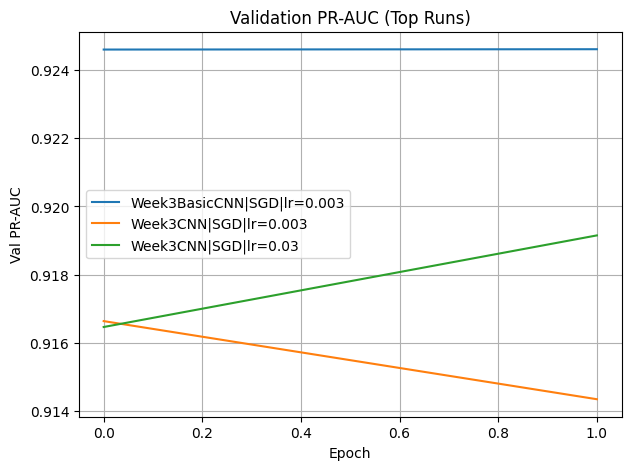

In [92]:
TOPK = 3
top_runs = summary_df.head(TOPK).to_dict(orient="records")

def get_history(model_name, lr, opt_name):
    return models[model_name][lr][opt_name]["history"].history

# Val AUC curves
plt.figure(figsize=(7,5))
for r in top_runs:
    h = get_history(r["model"], r["lr"], r["optimizer"])
    plt.plot(h["val_auc"], label=f'{r["model"]}|{r["optimizer"]}|lr={r["lr"]}')
plt.xlabel("Epoch"); plt.ylabel("Val ROC-AUC"); plt.title("Validation ROC-AUC (Top Runs)"); plt.legend(); plt.grid(True); plt.show()

# Val PR-AUC curves
plt.figure(figsize=(7,5))
for r in top_runs:
    h = get_history(r["model"], r["lr"], r["optimizer"])
    plt.plot(h["val_auprc"], label=f'{r["model"]}|{r["optimizer"]}|lr={r["lr"]}')
plt.xlabel("Epoch"); plt.ylabel("Val PR-AUC"); plt.title("Validation PR-AUC (Top Runs)"); plt.legend(); plt.grid(True); plt.show()

In [95]:
# Pick the best model
best = summary_df.iloc[0]
best_hist = models[best.model][best.lr][best.optimizer]["history"]
best_model = models[best.model][best.lr][best.optimizer]["model"]

best

model                 Week3BasicCNN
optimizer                       SGD
lr                            0.003
epochs_run                        2
best_epoch                        2
val_auc_best               0.931131
val_auprc_best             0.924605
train_auc_at_best          0.944615
train_loss_at_best         0.172564
val_loss_at_best           0.181036
Name: 0, dtype: object

{'best_val_f1': 0.4723361134529114, 'threshold': 0.05000000074505806}
{'test_threshold': 0.05000000074505806, 'precision': 0.4050115137559084, 'recall': 0.5714761847048843, 'f1': 0.4740549932326044}


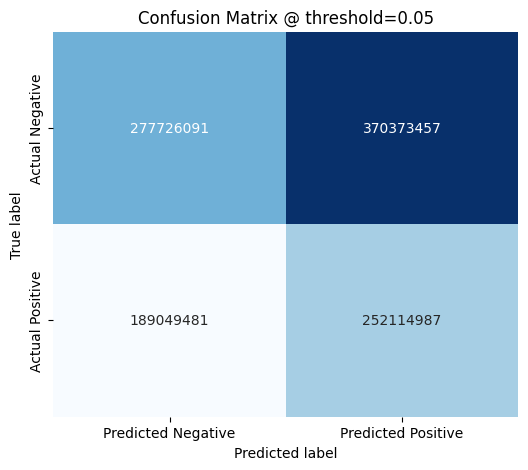

258/258 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - auc: 0.9020 - auprc: 0.9073 - loss: 0.2216
{'auc': 0.9020178318023682, 'auprc': 0.9072703123092651, 'loss': 0.22157785296440125}


In [97]:
# Collect val probabilities
val_logits, val_labels = [], []
for xb, yb in val_ds:
    val_logits.append(best_model(xb, training=False))
    val_labels.append(yb)
val_logits = tf.concat(val_logits, axis=0)
val_labels = tf.concat(val_labels, axis=0)
val_probs = tf.sigmoid(val_logits)

# Sweep thresholds to maximize F1
best_f1, best_t = 0.0, 0.5
for t in tf.linspace(0.05, 0.95, 19):
    preds = tf.cast(val_probs >= t, tf.int32)
    tp = tf.reduce_sum(tf.cast((preds==1) & (tf.cast(val_labels, tf.int32)==1), tf.float32))
    fp = tf.reduce_sum(tf.cast((preds==1) & (tf.cast(val_labels, tf.int32)==0), tf.float32))
    fn = tf.reduce_sum(tf.cast((preds==0) & (tf.cast(val_labels, tf.int32)==1), tf.float32))
    precision = tp / tf.maximum(tp+fp, 1.0)
    recall    = tp / tf.maximum(tp+fn, 1.0)
    f1 = 2*precision*recall / tf.maximum(precision+recall, 1e-8)
    if f1 > best_f1:
        best_f1, best_t = float(f1), float(t)

print({"best_val_f1": best_f1, "threshold": best_t})

# Thresholded test metrics
test_logits, test_labels = [], []
for xb, yb in test_ds:
    test_logits.append(best_model(xb, training=False))
    test_labels.append(yb)
test_logits = tf.concat(test_logits, axis=0)
test_labels = tf.cast(tf.concat(test_labels, axis=0), tf.int32)
test_probs = tf.sigmoid(test_logits)
test_preds = tf.cast(test_probs >= best_t, tf.int32)

tn = int(tf.reduce_sum(tf.cast((test_preds==0) & (test_labels==0), tf.int32)).numpy())
tp = int(tf.reduce_sum(tf.cast((test_preds==1) & (test_labels==1), tf.int32)).numpy())
fp = int(tf.reduce_sum(tf.cast((test_preds==1) & (test_labels==0), tf.int32)).numpy())
fn = int(tf.reduce_sum(tf.cast((test_preds==0) & (test_labels==1), tf.int32)).numpy())

precision = tp / max(tp+fp, 1)
recall    = tp / max(tp+fn, 1)
f1        = 2*precision*recall / max(precision+recall, 1e-8)

print({
    "test_threshold": best_t,
    "precision": precision, "recall": recall, "f1": f1
})

cm = np.array([[tn, fp],
               [fn, tp]])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

plt.title(f"Confusion Matrix @ threshold={best_t:.2f}")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

test_metrics = best_model.evaluate(test_ds, return_dict=True)
print(test_metrics)

### Conclusions (Step 5)

The pipeline works and the models seem to generalize properly.That being said, from these metrics we can conclude that the model doesn't really work, it needs a lot more training to be useful in any sense. 

ROC AUC and PR AUC both look pretty good but the confusion matrix shows that the predictions are all over the place, we have many false positives and false negatives.

The 0.05 threshold causes it to miss too many positive results. We could just use the raw output without threshold, but that means we'd get a general sense of how likely something is to be cancerous but no cutoff, so no confusion matrix would be possible either.

For this experiment to be meaningful, training on at least 20 epochs is probably necessary, at two epochs we could see that both models were still improving.
We could also explore different architectures and inspect misclassified data points to see if there's just too much noisy data (although this would be very hard to idenfity in this case).


#### References:
Tensorflow docs https://www.tensorflow.org/api_docs

Keras docs https://keras.io/guides/

Deep Learning By Ian Goodfellow, Yoshia bengio and Aaron Courville



In [104]:
import os

test_dir = f"{input_dir}/test"
test_ids = sorted([f[:-4] for f in os.listdir(test_dir) if f.endswith(".tif")])
test_df = pd.DataFrame({"id": test_ids})

def path_for_id_split(img_id: tf.Tensor, split: str = "test") -> tf.Tensor:
    # split is a Python str, ok to capture in a lambda/closure
    return tf.strings.join([input_dir, "/", split, "/", img_id, ".tif"])

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128

def make_test_ds(ids):
    paths = tf.constant(ids)  # string tensors
    ds = tf.data.Dataset.from_tensor_slices(paths)
    def _map(img_id):
        x = load_image(path_for_id_split(img_id, "test"))
        return x
    ds = ds.map(_map, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

kaggle_test_ds = make_test_ds(test_ids)

probs_list = []
for xb in kaggle_test_ds:
    logits = best_model(xb, training=False)
    probs = tf.sigmoid(logits).numpy().ravel()
    probs_list.append(probs)

preds = np.concatenate(probs_list, axis=0)

test_df["label"] = preds
submission_path = "submission.csv"
test_df.to_csv(submission_path, index=False)
print(f"Saved submission to {submission_path}, shape={test_df.shape}")

Saved submission to submission.csv, shape=(57458, 2)
